In [48]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()
import csv

from PIL import Image, ImageDraw
import os
import shutil
import glob

from mpl_toolkits.basemap import Basemap
from BetterMap import CreateMapBackground
import math
from statistics import mean 
import functools
import operator
import datetime
from pathlib import Path
from Utils import *

# Testing Audio
from IPython.lib.display import Audio

#there is currently a bug in panda's scatter_matrix that produces a warning that has no affect on what I'm doin :)
import warnings
warnings.filterwarnings("ignore")

# TESTING ZONE

In [2]:
#load in the data
df = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False, delim_whitespace=True)
df.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

df_center = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_Reduced_Trackfile.txt',header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
df_center.dropna(axis=0,how='any',subset=['Lat','Long'],inplace=True)

In [3]:
#make a dataframe that denotes groups based on a time interval - a new interval every 'minutes_between' amount of minutes
minutes_between = 30

def add_instances_to_df(df, minutes_between):
    instance = 0
    df_time = pd.DataFrame()
    df_time['instance'] = 0
    for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                    temp['instance'] = instance
                    df_time = df_time.append(temp, ignore_index=True)
                    instance+=1
    return df_time

df_time = add_instances_to_df(df, minutes_between)
df_time['distance'] = np.sqrt((df_time['Dist_East_West'] * df_time['Dist_East_West']) + 
                                (df_time['Dist_North_South'] * df_time['Dist_North_South']))
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230720 entries, 0 to 230719
Data columns (total 12 columns):
Day                 230720 non-null float64
Dist_East_West      230720 non-null float64
Dist_North_South    230720 non-null float64
Hour                230720 non-null float64
Lat                 230720 non-null float64
Long                230720 non-null float64
Min                 230720 non-null float64
Month               230720 non-null float64
Sec                 230720 non-null float64
Year                230720 non-null float64
instance            230720 non-null int64
distance            230720 non-null float64
dtypes: float64(11), int64(1)
memory usage: 21.1 MB


In [4]:
df_test = df_time.loc[df_time['instance'] == 1]
df_test

,Day,Dist_East_West,Dist_North_South,Hour,Lat,Long,Min,Month,Sec,Year,instance,distance
0,27.0,271.57100,138.4600,17.0,12.7452,-13.4960,56.0,8.0,9.7207,2017.0,1,304.831067
1,27.0,-23.98660,64.2929,17.0,12.0782,-16.2206,56.0,8.0,19.4011,2017.0,1,68.621673
2,27.0,820.72900,-200.6180,17.0,9.6958,-8.5119,56.0,8.0,36.8910,2017.0,1,844.892699
3,27.0,587.47000,-69.0520,17.0,10.8790,-10.6200,56.0,8.0,42.7955,2017.0,1,591.514311
4,27.0,370.07400,-176.5890,17.0,9.9119,-12.6214,56.0,8.0,46.1723,2017.0,1,410.046876
5,27.0,-142.33000,-154.3720,17.0,10.1117,-17.3002,56.0,8.0,47.9845,2017.0,1,209.972720
6,27.0,-139.46400,-154.8830,17.0,10.1071,-17.2740,56.0,8.0,47.9846,2017.0,1,208.420131
7,27.0,304.84900,121.9030,17.0,12.5963,-13.1908,56.0,8.0,48.2625,2017.0,1,328.318830
8,27.0,383.82700,-158.6750,17.0,10.0730,-12.4941,57.0,8.0,6.6318,2017.0,1,415.332303
9,27.0,381.27600,-155.5840,17.0,10.1008,-12.5171,57.0,8.0,6.6318,2017.0,1,411.798214


In [5]:
Mat = np.array(df_test.iloc[:,4:6])
print(Mat.shape)
Mat

(40, 2)


array([[ 12.7452, -13.496 ],
       [ 12.0782, -16.2206],
       [  9.6958,  -8.5119],
       [ 10.879 , -10.62  ],
       [  9.9119, -12.6214],
       [ 10.1117, -17.3002],
       [ 10.1071, -17.274 ],
       [ 12.5963, -13.1908],
       [ 10.073 , -12.4941],
       [ 10.1008, -12.5171],
       [ 10.8201, -10.632 ],
       [ 12.8407, -14.3968],
       [ 12.8622, -14.3702],
       [  8.6173,  -7.8062],
       [ 10.8929, -10.5472],
       [ 20.7493,  -7.3949],
       [ 20.783 ,  -7.3895],
       [  9.7396, -12.7869],
       [ 12.7511, -12.9329],
       [ 12.5222, -12.9993],
       [ 12.5511, -12.9798],
       [ 12.1187, -13.0955],
       [ 10.9334, -10.654 ],
       [ 10.9044, -10.4365],
       [ 10.8382, -10.557 ],
       [  8.5579,  -7.807 ],
       [ 21.1703, -13.5332],
       [ 10.835 , -10.5889],
       [ 10.8296, -10.633 ],
       [ 10.8991, -10.5721],
       [ 13.1397,  -6.1859],
       [ 13.1069,  -6.1611],
       [ 13.0934,  -6.1925],
       [ 13.1236,  -6.3306],
       [ 10.14

In [6]:
db = DBSCAN(eps=1.5, min_samples=3).fit(Mat)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_ 
  
# Number of clusters in labels, ignoring noise if present. 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 

# Black removed and is used for noise instead. 
unique_labels = set(labels) 

print(labels)
print(len(labels))
print(len(Mat))
print(n_clusters_)
#print(unique_labels)

[ 0  1  2  3  4  5  5  0  4  4  3  0  0  2  3 -1 -1  4  0  0  0  0  3  3
  3  2 -1  3  3  3  6  6  6  6  5  5  1  1  4  4]
40
40
7


### Testing Cluster Centers

In [29]:
cluster_lists_dict = {label: [Mat[i] for i in range(len(labels)) if labels[i] == label] for label in set(labels)}
cluster_center_dict = {label: [mean([x[0] for x in list_]), mean([x[1] for x in list_])] for label,list_ in cluster_lists_dict.items() }
cluster_center_dict

{0: [12.6234375, -13.4326625],
 1: [12.310733333333333, -16.134066666666666],
 2: [8.957, -8.0417],
 3: [10.870188888888888, -10.5823],
 4: [9.881516666666666, -12.691383333333333],
 5: [10.1318, -17.255000000000003],
 6: [13.1159, -6.217525],
 -1: [20.90086666666667, -9.4392]}

In [7]:
colors = ['y', 'b', 'g', 'r', 'c', 'm', 'k', 'w'] 

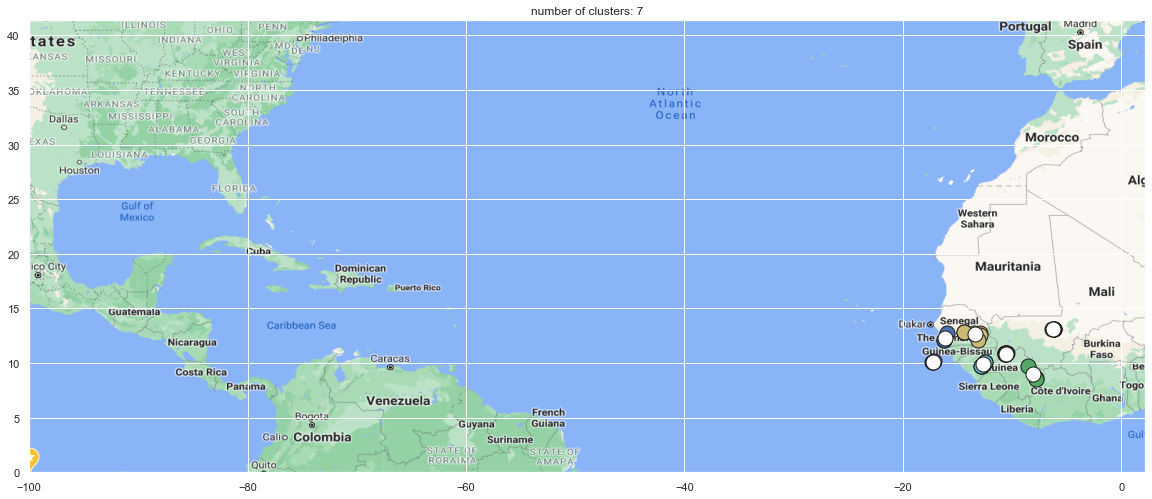

In [33]:
# MAP
img = np.asarray(mpimg.imread('MAP_ATLANTIC.PNG'))
plt.figure(figsize=(20,20))
plt.imshow(img,extent=[-100, 2.1734, 0, 41.3851])
# plt.imshow(image_to_plot,extent=[left_value, right_value, bottom_value, top_value])


# PLOT
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
  
    class_member_mask = (labels == k) 
  
    xy = Mat[class_member_mask & core_samples_mask] 
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor= col, 
                                      markeredgecolor='k',  
                                      markersize=15) 
  
    xy = Mat[class_member_mask & ~core_samples_mask] 
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=15)

# CLUSTER CENTERS
for key, point in cluster_center_dict.items():
    if key != -1:
        plt.plot(point[1], point[0], 'o', markerfacecolor='w', 
                                          markeredgecolor='k', 
                                          markersize=15)
    
# EXECUTE
plt.title('number of clusters: %d' %n_clusters_) 
plt.show()

# RELEASE ZONE

In [34]:
db_coords = []

In [35]:
#make a dataframe that denotes groups based on a time interval - a new interval every 'minutes_between' amount of minutes

def add_instances_to_df(df, minutes_between):
    instance = 0
    df_time = pd.DataFrame()
    df_time['instance'] = 0
    for x in range(len(df['Month'].unique())):
        month = df['Month'].unique()[x]
        for y in range(len(df[df['Month'] == df['Month'].unique()[x]]['Day'].unique())):
            day = df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]
            for z in range(len(df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique())):
                hour = df[df['Day'] == df[df['Month'] == df['Month'].unique()[x]]['Day'].unique()[y]]['Hour'].unique()[z]
                for w in range(0,60,minutes_between):
                    minute = w
                    temp = df[(df['Month'] == month) & (df['Day'] == day) & (df['Hour'] == hour) & (df['Min'] >= minute) & (df['Min'] <= minute + minutes_between)]
                    temp['instance'] = instance
                    df_time = df_time.append(temp, ignore_index=True)
                    instance+=1
    return df_time

In [62]:
def DFtoGIF_DBSCAN( df_source, epsilon = 1.5, samples = 3, minutes = 30, di='./data/dbscan/final_gif/', buffer = 10):

    ln = pd.read_csv('./Irma Storm centered/ATL_17_11_Irma_WWLLN_Locations.txt',header=None,names=["Year","Month","Day","Hour","Min","Sec","Lat","Long","Dist_East_West","Dist_North_South"],low_memory=False,sep=' ')
    year = 2017
    df = add_instances_to_df( df_source, minutes )
    colors = ['y', 'b', 'g', 'r', 'c', 'm', 'k']
    end = df['instance'].max()
    return_centroids = pd.DataFrame()
    
    img = np.asarray(mpimg.imread('MAP_ATLANTIC.PNG'))
    plt.figure(figsize=(20,20))
    plt.imshow(img,extent=[-100, 2.1734, 0, 41.3851])
    # plt.imshow(image_to_plot,extent=[left_value, right_value, bottom_value, top_value])

    if math.isnan(end):
        end = 0
        
    for current_segment in range(1, int(end)):
        
        df_temp = df[(df['instance'] == current_segment)]
        
        if(df_temp.shape[0] > 0):

            Mat = np.array(df_temp.iloc[:,4:6])
            db = DBSCAN( eps=epsilon, min_samples=samples ).fit(Mat)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_ 

            # Number of clusters in labels, ignoring noise if present. 
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 

            # Black removed and is used for noise instead. 
            unique_labels = set(labels) 
            
            # Cluster Centers
            cluster_lists_dict = {label: [Mat[i] for i in range(len(labels)) if labels[i] == label] for label in set(labels)}
            cluster_center_dict = {label: [mean([x[0] for x in list_]), mean([x[1] for x in list_])] for label,list_ in cluster_lists_dict.items() }
            
            # Store Cluster Centers in DF
            cluster_centers_aslist = [[current_segment, coordinate[0], coordinate[1], cluster_label] for cluster_label, coordinate in cluster_center_dict.items()]
            return_centroids = return_centroids.append(cluster_centers_aslist, ignore_index=True)            

            img = np.asarray(mpimg.imread('MAP_ATLANTIC.PNG'))
            fig = plt.figure(figsize=(20,20))
            plt.imshow(img,extent=[-100, 2.1734, 0, 41.3851])
            # plt.imshow(image_to_plot,extent=[left_value, right_value, bottom_value, top_value])

            for k, col in zip(unique_labels, colors): 
                if k == -1: 
                    # Black used for noise. 
                    col = 'k'

                class_member_mask = (labels == k) 

                xy = Mat[class_member_mask & core_samples_mask] 
                plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor= col, 
                                                  markeredgecolor='k',  
                                                  markersize=15) 

                xy = Mat[class_member_mask & ~core_samples_mask] 
                plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col, 
                                                  markeredgecolor='k', 
                                                  markersize=15)
                
            # CLUSTER CENTERS
            for key, point in cluster_center_dict.items():
                if key != -1:
                    plt.plot(point[1], point[0], 'o', markerfacecolor='w', 
                                                      markeredgecolor='k', 
                                                      markersize=15)
            
            month, day, hour, minute = int(df_temp['Month'].iloc[0]), int(df_temp['Day'].iloc[0]), int(df_temp['Hour'].iloc[0]), int(df_temp['Min'].iloc[0])
            #Save and close the figure
            plt.savefig('{}{}_{}_{}_{}_{}'.format(di,year,month,day,hour,minute),bbox_inches='tight')
            plt.close(fig)
    return return_centroids

Wall time: 8min 6s


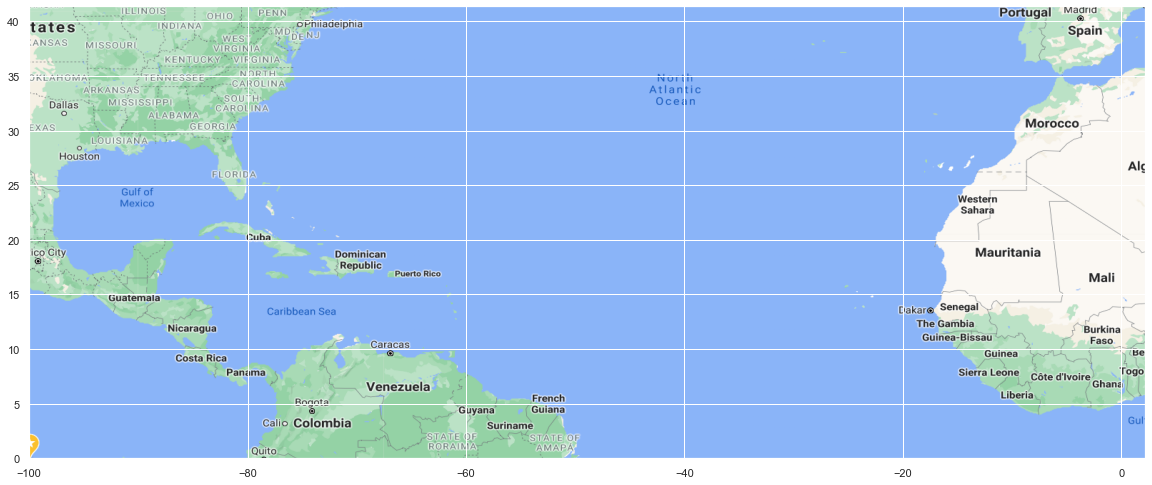

In [64]:
%%time
framerate = 4410
play_time_seconds = 3
t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)

centroid_df = DFtoGIF_DBSCAN( df )

Audio(audio_data, rate=framerate, autoplay=True)

In [67]:
centroid_df.shape

(4246, 4)

In [38]:
MakeGif('./data/dbscan/final_gif', './data/dbscan/', 'dbscan_3', 100, 'png')

In [57]:
ClearDir('./data/dbscan/final_gif')

Delete files from ./data/dbscan/final_gif y/n?
y
